In [1]:
from kan import *
import pytz
import time
import datetime
from data_process import data_process_without_norm
from sklearn.preprocessing import StandardScaler,MinMaxScaler

df = data_process_without_norm()
df = df.drop("entsoe",axis=1)
loc_tz = pytz.timezone('Europe/Zurich')
split_date_train_ = loc_tz.localize(datetime.datetime(2016,10,1,0,0,0,0))
split_date_train = loc_tz.localize(datetime.datetime(2016,12,1,0,0,0,0))
split_date_test = loc_tz.localize(datetime.datetime(2016,12,15,0,0,0,0))

df_train_ = df.loc[(split_date_train_ < df.index)]
df_train = df_train_.loc[df_train_.index <= split_date_train].copy()
_temp_df = df.loc[split_date_test > df.index]
df_test = _temp_df.loc[_temp_df.index > split_date_train].copy()

# 输入标准化
scaler_input = StandardScaler()
# scaler_input = MinMaxScalerr()
_temp_scaled_input_data = scaler_input.fit_transform(df_train.iloc[:,1:])
x_train_input = _temp_scaled_input_data

#输出标准化
scaler_output = StandardScaler()
# scaler_input = MinMaxScaler()
_temp_scaled_output_data = scaler_output.fit_transform(np.array(df_train.iloc[:,0]).reshape(-1,1))
x_train_label = _temp_scaled_output_data

#测试集标准化
x_test_input = scaler_input.transform(df_test.iloc[:,1:])
x_test_label = scaler_output.transform(np.array(df_test.iloc[:,0]).reshape(-1,1))


_temp_train_input = np.hstack((x_train_input[:,:8],x_train_input[:,-3:-1]))
_temp_train_label = x_train_label

_temp_test_input = np.hstack((x_test_input[:,:8],x_test_input[:,-3:-1]))
_temp_test_label = x_test_label


_temp_train_input_for_NN = x_train_input

_temp_test_input_for_NN = x_test_input


dataset = dict()
dataset_ = dict()
dataset['train_input'] = torch.tensor(_temp_train_input.astype(np.float32))
dataset_['train_input_for_NN'] = torch.tensor(_temp_train_input_for_NN.astype(np.float32))
dataset['train_label'] = torch.tensor(_temp_train_label.astype(np.float32))

dataset['test_input'] = torch.tensor(_temp_test_input.astype(np.float32))
dataset_['test_input_for_NN'] = torch.tensor(_temp_test_input_for_NN.astype(np.float32))
dataset['test_label'] = torch.tensor(_temp_test_label.astype(np.float32))

# dataset['test_input'] = torch.tensor(np.array(X_test)[:,:32])
# dataset['test_label'] = torch.tensor(np.array(y_test))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



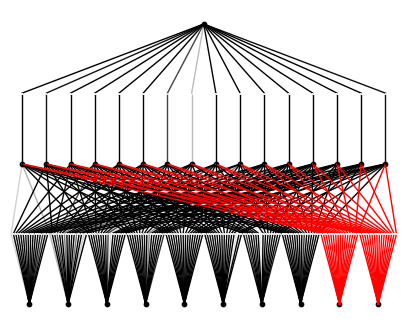

In [2]:
# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[10,16,1], grid=10, k=3, seed=0, device=device)# create dataset f(x,y) = exp(sin(pi*x)+y^2)

model(dataset['train_input']);

for i in range(16):
    model.fix_symbolic(0,9,i,'sin',fit_params_bool=False)
    model.fix_symbolic(0,8,i,'sin',fit_params_bool=False)

# plot KAN at initialization
model(dataset['train_input']);
model.plot(beta=100);

In [3]:
# train the model
start_time = time.time()
model.train(dataset, opt="LBFGS", steps=50, batch=128, lr=0.01, lamb=0.01, lamb_entropy=10.);
end_time = time.time()
print(end_time - start_time)

train loss: 3.66e-01 | test loss: 6.46e-01 | reg: 7.70e+01 : 100%|██| 50/50 [00:46<00:00,  1.08it/s]

46.473607540130615


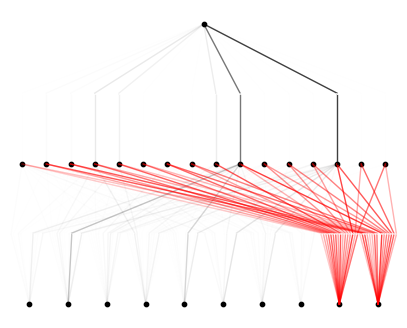

In [4]:
model.plot()

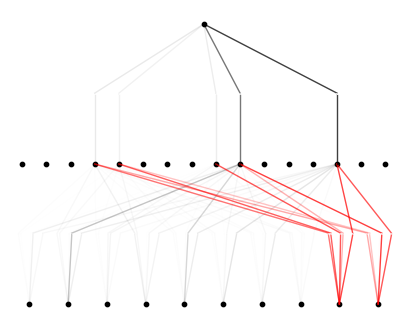

In [5]:
model.prune(threshold=1e-2)
model.plot(mask=True)

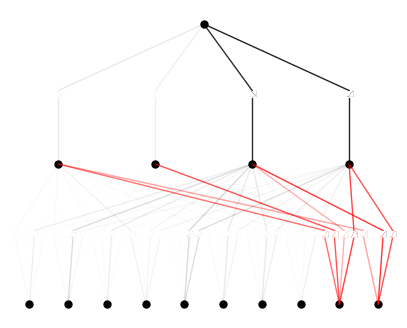

In [6]:
model = model.prune(2e-2)
model(dataset['train_input'])
model.plot()

In [7]:
# train the model
model.train(dataset, opt="LBFGS", steps=50, batch=128, lr=0.01, lamb=0.01);

train loss: 2.93e-01 | test loss: 6.04e-01 | reg: 1.38e+01 : 100%|██| 50/50 [00:17<00:00,  2.90it/s]


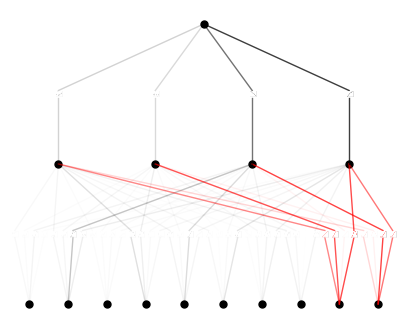

In [8]:
model.plot()

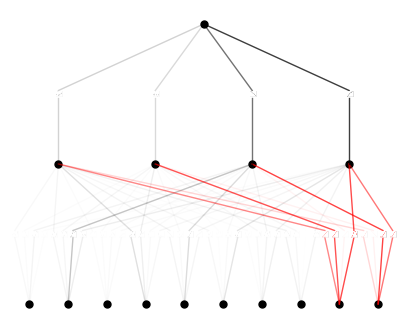

In [9]:
model.prune(threshold=8e-3)
model.plot(mask=True)

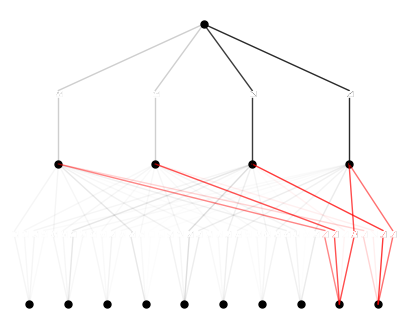

In [10]:
model = model.prune()
model(dataset['train_input'])
model.plot()

In [11]:
# train the model
model.train(dataset, opt="LBFGS", steps=50, batch=128, lr=0.01, lamb=0.01);

train loss: 2.96e-01 | test loss: 5.38e-01 | reg: 1.35e+01 : 100%|██| 50/50 [00:18<00:00,  2.65it/s]


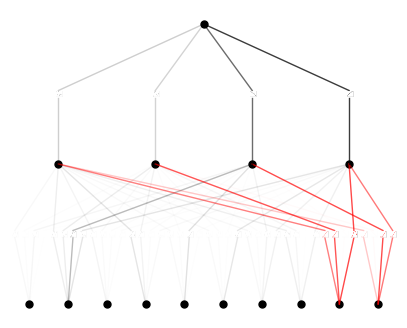

In [12]:
model.plot()

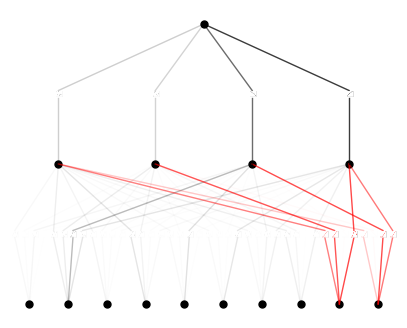

In [13]:
model.prune(threshold=1e-2)
model.plot(mask=True)

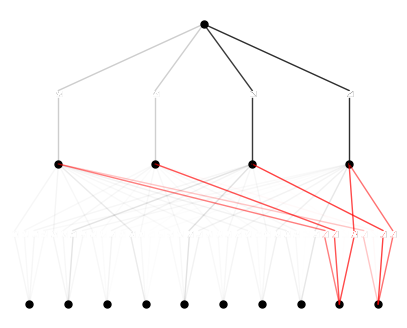

In [14]:
model = model.prune(3e-2)
model(dataset['train_input'])
model.plot()

In [15]:
# train the model
model.train(dataset, opt="LBFGS", steps=50, batch=128, lr=0.01, lamb=0.01);

train loss: 2.94e-01 | test loss: 6.14e-01 | reg: 1.33e+01 : 100%|██| 50/50 [00:16<00:00,  2.98it/s]


In [16]:
inter_units = 4
func_0 = []
for i in range(10):
    for j in range(inter_units):
        func_0.append(model.suggest_symbolic(0,i,j)[0])

func_1 = []
for i in range(inter_units):
    for j in range(1):
        func_1.append(model.suggest_symbolic(1,i,j)[0])

for i,j in enumerate(func_0):
    if j in ['abs','sgn']:
        func_0[i] = 'x^2'

for i,j in enumerate(func_0):
    if j in ['abs','sgn']:
        func_0[i] = 'x^2'

for i in range(10):
    for j in range(inter_units):
        model.fix_symbolic(0,i,j,func_0[i*inter_units+j],fit_params_bool=True)
for i in range(inter_units):
    for j in range(1):
        model.fix_symbolic(0,i,j,func_1[i*1+j],fit_params_bool=True)

function , r2
sin , 0.9322519898414612
gaussian , 0.8690966963768005
abs , 0.710541844367981
x^2 , 0.5594447255134583
cosh , 0.5565597414970398
function , r2
tanh , 0.9983235597610474
sigmoid , 0.9971495866775513
x^4 , 0.9967139363288879
gaussian , 0.996543824672699
arctan , 0.9958255290985107
function , r2
sin , 0.9704199433326721
gaussian , 0.9692184925079346
abs , 0.9196247458457947
x^2 , 0.7717990875244141
cosh , 0.7612127065658569
function , r2
abs , 0.9228219389915466
gaussian , 0.886614978313446
sin , 0.8848617672920227
x^2 , 0.8814826607704163
x^3 , 0.8802754878997803
function , r2
tanh , 0.8476008176803589
gaussian , 0.8393567800521851
arctan , 0.8030382394790649
sigmoid , 0.7894481420516968
sin , 0.7813355326652527
function , r2
tanh , 0.8663267493247986
gaussian , 0.8607699275016785
sin , 0.8544906377792358
abs , 0.8316800594329834
arctan , 0.8276182413101196
function , r2
gaussian , 0.9805622100830078
tanh , 0.9739865660667419
arctan , 0.9716041684150696
sigmoid , 0.9668304

In [17]:
model.train(dataset, opt="LBFGS", lr=0.01, steps=50, batch=128, lamb=0.01);

train loss: 3.81e-01 | test loss: 5.46e-01 | reg: 1.35e+01 : 100%|██| 50/50 [00:16<00:00,  3.04it/s]


In [18]:
model.symbolic_formula()[0]

[-0.83*cosh(-0.e-2*(1 - 0.76*x_8)**2 + 0.01*sin(3.12*x_1 - 6.13) + 0.36*sin(1.1*x_10 - 3.74) + 0.01*sin(3.89*x_6 - 1.68) + 0.02*sin(3.32*x_7 - 2.7) - 2.27 - 0.09*exp(-2.32*(-x_5 - 0.51)**2) + 0.17*exp(-17.66*(-0.44*x_2 - 1)**2)) - 2.85*cosh(-0.12*(-0.28*x_1 - 1)**2 + 0.19*sin(1.23*x_10 - 6.79) + 0.01*sin(4.26*x_5 + 2.09) - 0.27*sin(1.88*x_9 - 8.37) + 0.05*tanh(4.53*x_8 + 8.6) - 1.1 + 0.07*exp(-3.45*(-x_7 - 0.35)**2) - 0.05*exp(-9.59*(-0.49*x_6 - 1)**2) + 0.04*exp(-34.43*(-0.38*x_4 - 1)**2) + 0.08*exp(-15.05*(-0.45*x_2 - 1)**2)) + 9.14]

In [19]:
from xgboost import XGBRegressor as XGBR
start_time = time.time()
XGBR_reg = XGBR(n_estimators=100).fit(dataset['train_input'].detach().numpy(), dataset['train_label'].detach().numpy())
XGBR_pre = XGBR_reg.predict(dataset['test_input'].detach().numpy())
end_time = time.time()
print(end_time - start_time)

0.08880186080932617


In [20]:
loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(dataset['train_input'], dataset['train_label']), batch_size=128, shuffle=True)

num_inputs, num_outputs= 10, 1
net_1 = nn.Sequential()
net_1.add_module('linear1',nn.Linear(num_inputs,16))
net_1.add_module('sigmoid',nn.Sigmoid())
net_1.add_module('linear2',nn.Linear(16,1))

net_2 = nn.Sequential()
net_2.add_module('linear1',nn.Linear(num_inputs,2))
net_2.add_module('sigmoid',nn.Sigmoid())
net_2.add_module('linear2',nn.Linear(2,1))

In [21]:
def RMSE(_pre,_actual):
    MSE = ((_pre-_actual)**2)/15/24   
    return np.sqrt(MSE.sum())
    
def MAE(_pre,_actual):
    return (np.abs((_pre-_actual))).sum()/15/24
    
def MAPE(_pre,_actual):
    return ((np.abs((_pre-_actual)))/_actual).sum()/15/24
    
def evaluation(_pre,_actual): 
    return [RMSE(_pre,_actual),MAE(_pre,_actual),MAPE(_pre,_actual)]
    

In [22]:
loss_func_1 = torch.nn.MSELoss()
optimizer_1 = torch.optim.Adam(net_1.parameters(), lr = 0.01)
loss_func_2 = torch.nn.MSELoss()
optimizer_2 = torch.optim.Adam(net_2.parameters(), lr = 0.01)

start_time = time.time()
for epoch in range(50):
    for step, (x,y) in enumerate(loader):          # for each training step
        output = net_1(x)                           # get output for every net
        loss_1 = loss_func_1(output, y)                # compute loss for every net
        optimizer_1.zero_grad()                             # clear gradients for next train
        loss_1.backward()                             # backpropagation, compute gradients
        optimizer_1.step()                                  # apply gradients
end_time = time.time()
print(end_time - start_time)

start_time = time.time()
for epoch in range(50):
    for step, (x,y) in enumerate(loader):          # for each training step
        output = net_2(x)                           # get output for every net
        loss_2 = loss_func_2(output, y)                # compute loss for every net
        optimizer_2.zero_grad()                             # clear gradients for next train
        loss_2.backward()                             # backpropagation, compute gradients
        optimizer_2.step()                                  # apply gradients
end_time = time.time()
print(end_time - start_time)

0.6281189918518066
0.6223201751708984


In [23]:
pre_ann_1 = net_1.forward(dataset['test_input']).detach().numpy()
pre_ann_2 = net_2.forward(dataset['test_input']).detach().numpy()
pre_KAN = model.forward(dataset['test_input']).detach().numpy()

actual = scaler_output.inverse_transform(dataset['test_label'].reshape(-1,1))
pre_ann_1_ = scaler_output.inverse_transform(pre_ann_1)
pre_ann_2_ = scaler_output.inverse_transform(pre_ann_2)
pre_KAN_ = scaler_output.inverse_transform(pre_KAN)
XGBR_pre_ = scaler_output.inverse_transform(XGBR_pre.reshape(-1,1))

result = dict()
result["ann_1"] = evaluation(pre_ann_1_,actual)
result["ann_2"] = evaluation(pre_ann_2_,actual)
result["KAN"] = evaluation(pre_KAN_,actual)
result["XGBR"] = evaluation(XGBR_pre_,actual)

In [24]:
result

{'ann_1': [474.11187919006295, 365.1528020553671, 0.04687593435949475],
 'ann_2': [608.3627378933614, 487.2060748899832, 0.062446496498513616],
 'KAN': [426.499225941342, 339.766721754561, 0.04462075229841861],
 'XGBR': [403.95298797118335, 339.32913419594587, 0.04381485861530165]}

In [25]:
# class SiLU(nn.Module):
#     @staticmethod
#     def forward(x):
#         return x * torch.sigmoid(x)

# 定义第一个模块
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(10, 16)
        self.fc2 = nn.Linear(16, 1)
        self.silu_layer = torch.nn.SiLU()

 
    def forward(self, x):
        x = self.fc1(x)
        x = torch.sigmoid(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        x = self.silu_layer(x)
        return x

In [26]:
# 连接模块
class KAN_ADD_NN(nn.Module):
    def __init__(self, module1, module2):
        super(KAN_ADD_NN, self).__init__()
        self.module1 = module1
        self.module2 = module2
        self.fc1 = nn.Linear(2,1)
 
    def forward(self, x1, x2):
        # with torch.no_grad():
        y1 = self.module1(x1)
        y2 = self.module2(x2)  
        y = self.fc1(torch.cat((y1,y2), 1))
        return y

    def loss_func(self, x1, x2, y_actual):
        y_pre = self.forward(x1,x2)
        loss = torch.mean((y_pre-y_actual)**2)
        _W_loss = []
        for _i,_j in enumerate(KAN_ADD_NN.fc1.parameters()):
            if _i == 0:
                loss += 10*torch.mean(torch.abs(_j[:,1]))
            
        return loss
 

In [27]:
# loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(dataset['train_input'],dataset_['train_input_for_NN'], dataset['train_label']), batch_size=128, shuffle=True)
module2 = NN()
# 实例化复合模块
KAN_ADD_NN = KAN_ADD_NN(model, module2)
loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(dataset['train_input'],dataset['train_input'], dataset['train_label']), batch_size=128, shuffle=True)

In [28]:
# loss_func_1 = torch.nn.MSELoss()
optimizer_1 = torch.optim.Adam(KAN_ADD_NN.parameters(), lr = 0.0002)

for epoch in range(100):
    for step, (x,y,z) in enumerate(loader):          # for each training step
        output = KAN_ADD_NN(x,y)                           # get output for every net
        loss_1 = KAN_ADD_NN.loss_func(x, y, z)                # compute loss for every net
        optimizer_1.zero_grad()                             # clear gradients for next train
        loss_1.backward()                             # backpropagation, compute gradients
        optimizer_1.step()                                  # apply gradients


In [29]:
def RMSE(_pre,_actual):
    MSE = ((_pre-_actual)**2)/15/24   
    return np.sqrt(MSE.sum())
    
def MAE(_pre,_actual):
    return (np.abs((_pre-_actual))).sum()/15/24
    
def MAPE(_pre,_actual):
    return ((np.abs((_pre-_actual)))/_actual).sum()/15/24
    
def evaluation(_pre,_actual): 
    return [RMSE(_pre,_actual),MAE(_pre,_actual),MAPE(_pre,_actual)]
    

In [30]:
pre_ann_3 = KAN_ADD_NN.forward(dataset['test_input'],dataset['test_input']).detach().numpy()
actual = scaler_output.inverse_transform(dataset['test_label'].reshape(-1,1))
pre_ann_3_ = scaler_output.inverse_transform(pre_ann_3)
result = dict()
result["KAN+ANN"] = evaluation(pre_ann_3_,actual)

In [31]:
result

{'KAN+ANN': [391.6646499055244, 315.84912895477515, 0.04122918352251143]}

In [32]:
for _i,_j in enumerate(KAN_ADD_NN.fc1.parameters()):
    if _i == 0:
        print("Weighted Coefficients: ",_j.detach().numpy()[0])
    if _i == 1:
        print("Bias: ",_j.detach().numpy()[0])

Weighted Coefficients:  [ 0.78895754 -0.04826275]
Bias:  0.23992495


In [36]:
pre_ann_4 = KAN_ADD_NN.module1(dataset['test_input']).detach().numpy()
pre_ann_4_ = scaler_output.inverse_transform(0.78895754*pre_ann_4+0.23992495)
result["Revised KAN"] = evaluation(pre_ann_4_,actual)

In [37]:
result

{'KAN+ANN': [391.6646499055244, 315.84912895477515, 0.04122918352251143],
 'Revised KAN': [386.9171313648594, 311.26288350719176, 0.04066911504290151]}

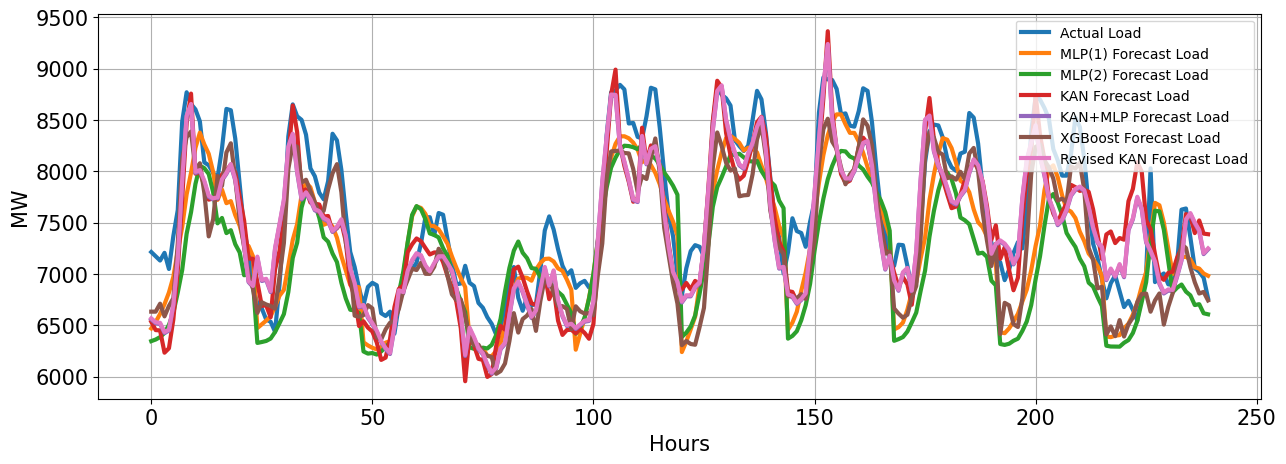

In [38]:
f = plt.figure(figsize=(15,5))
plt.plot(actual[:240],linewidth=3,label="Actual Load")
plt.plot(pre_ann_1_[:240],linewidth=3,label="MLP(1) Forecast Load")
plt.plot(pre_ann_2_[:240],linewidth=3,label="MLP(2) Forecast Load")
plt.plot(pre_KAN_[:240],linewidth=3,label="KAN Forecast Load")
plt.plot(pre_ann_3_[:240],linewidth=3,label="KAN+MLP Forecast Load")
plt.plot(XGBR_pre_[:240],linewidth=3,label="XGBoost Forecast Load")
plt.plot(pre_ann_4_[:240],linewidth=3,label="Revised KAN Forecast Load")
# plt.ylim(6500,8000)
plt.grid()
plt.legend(fontsize=10)
plt.xlabel("Hours",fontsize=15)
plt.ylabel("MW",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()
f.savefig("./COMPARE_WINTER.svg",format="svg",dpi=300)